In [15]:
import os

print(os.getcwd())
os.chdir('/home/jelinek/recetox/')

from ml.pipeline import FeitDataPipeline

from tensorflow import keras

from cfg import *

from livelossplot import PlotLossesKerasTF

name = 'MySimpleCNN_Inception_module-v2-reduced-inception-residual-small-tiny'

/home/jelinek/recetox


In [16]:
from tensorflow.keras.optimizers import schedules, Adam


def convolutional_block(X, f, filters, stage, block, s=2):
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters

    X_shortcut = X

    X = keras.layers.Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '2a',
               kernel_initializer=keras.initializers.GlorotUniform(seed=0))(X)
    X = keras.layers.BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = keras.layers.Activation('relu')(X)

    X = keras.layers.Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b',
               kernel_initializer=keras.initializers.GlorotUniform(seed=0))(X)
    X = keras.layers.BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = keras.layers.Activation('relu')(X)

    X = keras.layers.Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c',
               kernel_initializer=keras.initializers.GlorotUniform(seed=0))(X)
    X = keras.layers.BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X_shortcut = keras.layers.Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '1',
                        kernel_initializer=keras.initializers.GlorotUniform(seed=0))(X_shortcut)
    X_shortcut = keras.layers.BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    X = keras.layers.Add()([X, X_shortcut])
    X = keras.layers.Activation('relu')(X)

    return X


def identity_block(X, f, filters, stage, block):
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters

    X_shortcut = X

    X = keras.layers.Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2a',
               kernel_initializer=keras.initializers.GlorotUniform(seed=0))(X)
    X = keras.layers.BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = keras.layers.Activation('relu')(X)

    X = keras.layers.Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b',
               kernel_initializer=keras.initializers.GlorotUniform(seed=0))(X)
    X = keras.layers.BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = keras.layers.Activation('relu')(X)

    X = keras.layers.Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c',
               kernel_initializer=keras.initializers.GlorotUniform(seed=0))(X)
    X = keras.layers.BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X = keras.layers.Add()([X, X_shortcut])  # SKIP Connection
    X = keras.layers.Activation('relu')(X)

    return X


class MySimpleCnn_Feit(FeitDataPipeline):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.model = self.get_compiled_model()
        self.params.name = name
        self.params.epochs = 200
        self.batch_size = 16
        self.params.tile_size = 256

    @staticmethod
    def get_compiled_model(input_shape=(256, 256, 3)):
        X_input = keras.layers.Input(input_shape)

        X = keras.layers.ZeroPadding2D((3, 3))(X_input)

        X = keras.layers.Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=keras.initializers.GlorotUniform(seed=0))(X)
        X = keras.layers.BatchNormalization(axis=3, name='bn_conv1')(X)
        X = keras.layers.Activation('relu')(X)
        X = keras.layers.MaxPooling2D((3, 3), strides=(2, 2))(X)

        X = convolutional_block(X, f=3, filters=[8, 8, 32], stage=2, block='a', s=1)
        X = identity_block(X, 3, [8, 8, 32], stage=2, block='b')
        X = identity_block(X, 3, [8, 8, 32], stage=2, block='c')

        X = convolutional_block(X, f=3, filters=[16, 16, 64], stage=3, block='a', s=2)
        X = identity_block(X, 3, [16, 16, 64], stage=3, block='b')
        X = identity_block(X, 3, [16, 16, 64], stage=3, block='d')

        X = convolutional_block(X, f=3, filters=[32, 32, 128], stage=4, block='a', s=2)
        X = identity_block(X, 3, [32, 32, 128], stage=4, block='b')
        X = identity_block(X, 3, [32, 32, 128], stage=4, block='f')

        X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=5, block='a', s=2)
        X = identity_block(X, 3, [64, 64, 256], stage=5, block='b')
        X = identity_block(X, 3, [64, 64, 256], stage=5, block='c')

        X = keras.layers.AveragePooling2D(pool_size=(2, 2), padding='same')(X)

        X = keras.layers.Flatten()(X)
        X = keras.layers.Dense(units=12, activation='softmax')(X)

        model = keras.Model(inputs=X_input, outputs=X, name='MySimpleCNN_Inception_module-v2-reduced-inception-residual-small-tiny')

        model.summary()

        return model

    # def get_optimizer(self):
    #     lr_schedule = schedules.ExponentialDecay(
    #                     initial_learning_rate=1e-3,
    #                     decay_steps=80,
    #                     decay_rate=0.1,
    #                     staircase=True)
    #
    #     return ( Adam(
    #         learning_rate=lr_schedule,
    #         beta_1=0.99,
    #         beta_2=0.9999))

    def _train_model(self, data_train, data_valid):

        self.model.fit(data_train,
                       steps_per_epoch=250,
                       epochs=200,
                       shuffle=True,
                       validation_data=data_valid,
                       validation_freq=10,
                       verbose=1,
                       callbacks=[self.tensorboard, PlotLossesKerasTF()])

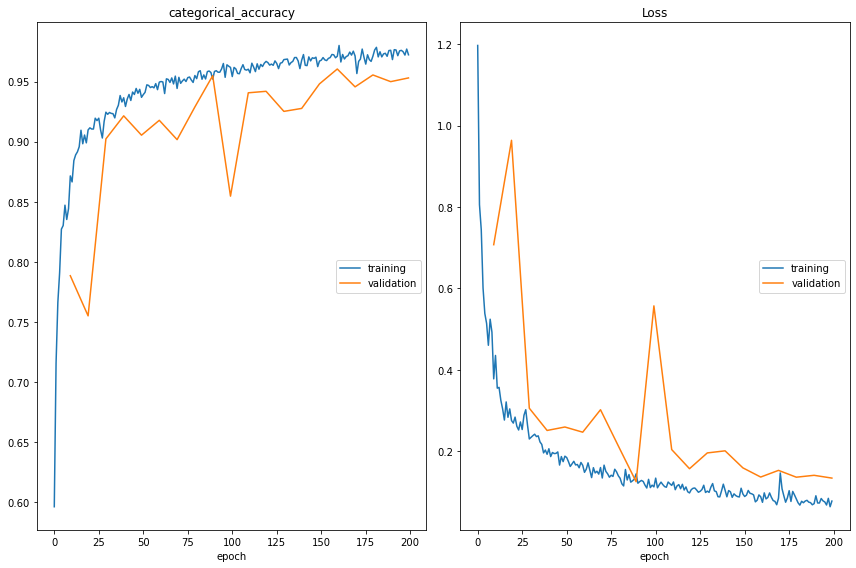

categorical_accuracy
	training         	 (min:    0.596, max:    0.980, cur:    0.972)
	validation       	 (min:    0.755, max:    0.960, cur:    0.953)
Loss
	training         	 (min:    0.063, max:    1.197, cur:    0.077)
	validation       	 (min:    0.125, max:    0.964, cur:    0.134)
102/102 [==============================] - 6s 54ms/step - loss: 0.1338 - categorical_accuracy: 0.9530
Measuring time
--Iteration 10/10
Batch size: 16
Mean time per tile 0.5820ms
Confusion Matrix
[[331   2   0   0   0   0   0   0   0   0   2   0]
 [  3  54   6   1   0   0   0   0   0   0   0   0]
 [  3   3 138   0   1   0   0   0   0   0   0   0]
 [  0   0   0  11   0   0   0   0   0   0   0   0]
 [  0   0   1   1 541   0   0   0   0   0   1   0]
 [  0   0   0   0   0   1   0   0   0   0   0   0]
 [  0   1   3   0   0   0  68   5   0   0   0   0]
 [  0   1   1   0   0   0   1  83   0   0   0   0]
 [  0   0   0   0   0   0   1   0   0   0   0   0]
 [  0   0   1   0   0   0   0   0   0   0   0   0]
 [ 11

In [17]:
pipeline = MySimpleCnn_Feit(train_data_dir='data/Feit_colon-annotation-tiles-256/data_train/',
                            valid_data_dir='data/Feit_colon-annotation-tiles-256/data_valid/')

keras.utils.plot_model(pipeline.model, 'model-figs/' + name + '.png')
pipeline.execute_pipeline(perform_validation=True, perform_test_segmentation=False)


In [18]:
pipeline.save_pipeline()

/home/jelinek/anaconda3/envs/recetox/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [19]:
pipeline = FeitDataPipeline.load_pipeline(pipeline_name=name)

In [20]:
from ml.eval import evaluate_segmentation_on_feit_annotation

evaluation_path = Path('data/Feit_colon-annotation_valid/')

segmentation_dir = Path('segmentations') / pipeline.params.name

evaluate_segmentation_on_feit_annotation(evaluation_path, pipeline.build_segmenter(),
                                         32, pipeline.params.class_names,
                                         save_segmentations=True, segmentations_dir=segmentation_dir,
                                         neighbourhood_size=1)

Processing region 120 out of 120
Processing image took 1937.998866558075 seconds
Saving file...
File saved to segmentations/MySimpleCNN_Inception_module-v2-reduced-inception-residual-small-tiny/ns-adenoca-colon-15071-2019-20x-he-4.tiff
Processing region 255 out of 255
Processing image took 4545.7919154167175 seconds
Saving file...
File saved to segmentations/MySimpleCNN_Inception_module-v2-reduced-inception-residual-small-tiny/ns-adenoca-colon-15072-2019-20x-he-a2.tiff
Processing region 255 out of 255
Processing image took 4336.646514415741 seconds
Saving file...
File saved to segmentations/MySimpleCNN_Inception_module-v2-reduced-inception-residual-small-tiny/ns-adenoca-colon-3043-2019-20x-he-a1.tiff
Processing region 567 out of 567
Processing image took 9844.7985932827 seconds
Saving file...
File saved to segmentations/MySimpleCNN_Inception_module-v2-reduced-inception-residual-small-tiny/pop-ca-colon-1708-2019-5-20x-he.tiff
[[485808   5758   1961      0    250    129      3   1110    

In [21]:
pipeline.model.summary()


Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_3 (ZeroPadding2D (None, 262, 262, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 128, 64) 9472        zero_padding2d_3[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 128, 128, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________